In [1]:
import tensorflow as tf

import os
import tensorflow_datasets as tfds

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [3]:
strategy = tf.distribute.TPUStrategy(resolver)

In [4]:
!pip install hickle
import hickle as hkl
import os
import matplotlib.pyplot as plt
from keras import layers,Input,Sequential
from keras.layers import Dense,Flatten,Reshape,Conv2DTranspose,Conv2D,MaxPooling2D,Reshape,Resizing,Dropout,UpSampling2D,BatchNormalization
from tensorflow.keras import datasets, layers, models, losses, Model
from random import randint
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from google.colab  import drive
drive.mount("/gdrive")
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [5]:
load_hkl = hkl.load("/gdrive/My Drive/Yedek/Autoencoder_Datasets_v2/Static/Frontal.hkl")
X_train=load_hkl['xtrain'] / 255.
X_test=load_hkl['xtest'] / 255.
y_train=load_hkl['ytrain']
y_test=load_hkl['ytest']

In [6]:
X_train.shape

(176, 480, 640, 3)

In [10]:
class CNN_Autoencoder(Model):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=X_train.shape[1:]),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.MaxPooling2D(2, strides=2),
            layers.Conv2D(1, 3, strides=1, padding='same', activation='relu')])

        self.decoder = tf.keras.Sequential([
            layers.Conv2D(1, 3, strides=1, padding='same', activation='relu'),
            layers.UpSampling2D(2),
            layers.Conv2D(4, 3, strides=1, padding='same', activation='relu'),
            layers.UpSampling2D(2),
            layers.Conv2D(8, 3, strides=1, padding='same', activation='relu'),
            layers.UpSampling2D(2),
            layers.Conv2D(16, 3, strides=1, padding='same', activation='relu'),
            layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
epochs=40

In [26]:
with strategy.scope():
  cnn_autoencoder_front=CNN_Autoencoder()
  cnn_autoencoder_front.compile(optimizer='adam',  loss='mse',metrics=['accuracy'])
history=cnn_autoencoder_front.fit(X_train,X_train,epochs=epochs,
      batch_size=16, shuffle=True,validation_data=(X_test,X_test))

Epoch 1/40
11/11 [==============================] - 22s 1s/step - loss: 0.0517 - accuracy: 0.6575 - val_loss: 0.0435 - val_accuracy: 0.6920
Epoch 2/40
11/11 [==============================] - 2s 234ms/step - loss: 0.0408 - accuracy: 0.6904 - val_loss: 0.0368 - val_accuracy: 0.6919
Epoch 3/40
11/11 [==============================] - 3s 241ms/step - loss: 0.0380 - accuracy: 0.6900 - val_loss: 0.0357 - val_accuracy: 0.6914
Epoch 4/40
11/11 [==============================] - 3s 241ms/step - loss: 0.0365 - accuracy: 0.6900 - val_loss: 0.0338 - val_accuracy: 0.6925
Epoch 5/40
11/11 [==============================] - 3s 240ms/step - loss: 0.0331 - accuracy: 0.6932 - val_loss: 0.0282 - val_accuracy: 0.7035
Epoch 6/40
11/11 [==============================] - 3s 255ms/step - loss: 0.0257 - accuracy: 0.8389 - val_loss: 0.0195 - val_accuracy: 0.9099
Epoch 7/40
11/11 [==============================] - 2s 236ms/step - loss: 0.0180 - accuracy: 0.9189 - val_loss: 0.0142 - val_accuracy: 0.9367
Epoch 8/

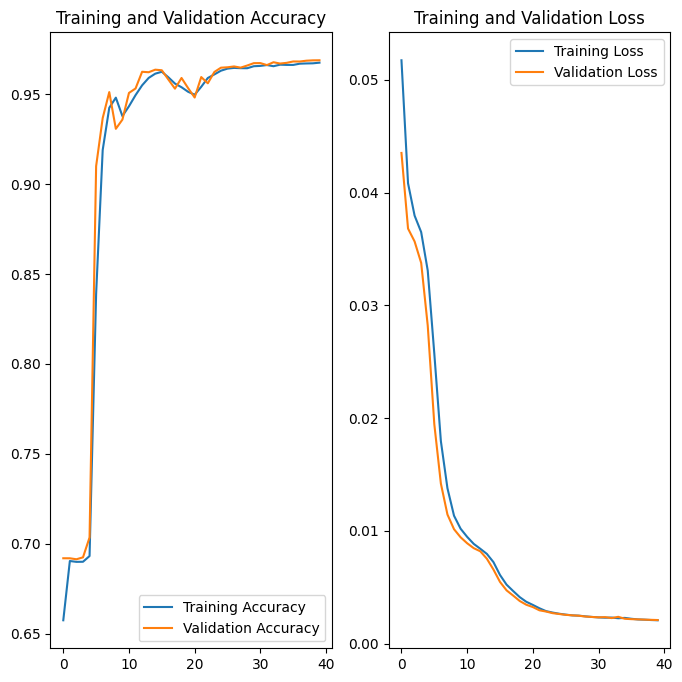

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
cnn_autoencoder_front.save('/gdrive/My Drive/Models_Static_v2/Frontal', options=save_locally)

In [29]:
with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    reconstructed_front = tf.keras.models.load_model('/gdrive/My Drive/Models_Static_v2/Frontal', options=load_locally)

In [30]:
xm_train=reconstructed_front.encoder(X_train)
xm_test=reconstructed_front.encoder(X_test)


In [31]:
xm_train.shape

TensorShape([176, 60, 80, 1])

In [32]:
xm_train.shape[0]

176

In [33]:
xm_train=tf.reshape(xm_train,[xm_train.shape[0],-1])
xm_test=tf.reshape(xm_test,[xm_test.shape[0],-1])

## **Machine Learning**

In [34]:
from sklearn.metrics import classification_report

In [35]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

xm_train=scaler.fit_transform(xm_train)
xm_test=scaler.transform(xm_test)

In [36]:
from sklearn.svm import SVC

svc=SVC(kernel="sigmoid")
svc.fit(xm_train, y_train)

SVC(kernel='sigmoid')

In [37]:
y_pred=svc.predict(xm_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm=confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

[[47  4]
 [ 5 19]]
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91        51
         1.0       0.83      0.79      0.81        24

    accuracy                           0.88        75
   macro avg       0.86      0.86      0.86        75
weighted avg       0.88      0.88      0.88        75



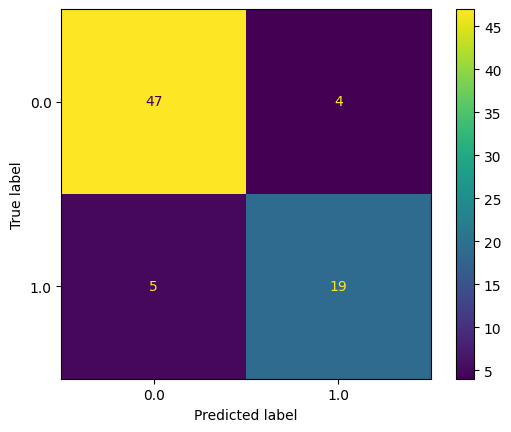

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()